# Simple zonal statistics example

In [1]:
import numpy as np
import pandas as pd
import geopandas
import geoplot
import geoplot.crs as gcrs
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
import mapclassify as mc
import seaborn as sns
import rasterio
from rasterio.plot import show
from rasterio.warp import reproject
from osgeo import gdal
from rasterstats import zonal_stats

In [2]:
counties = geopandas.read_file('./data/USA_adm_shp/USA_adm2.shp')

<AxesSubplot:>

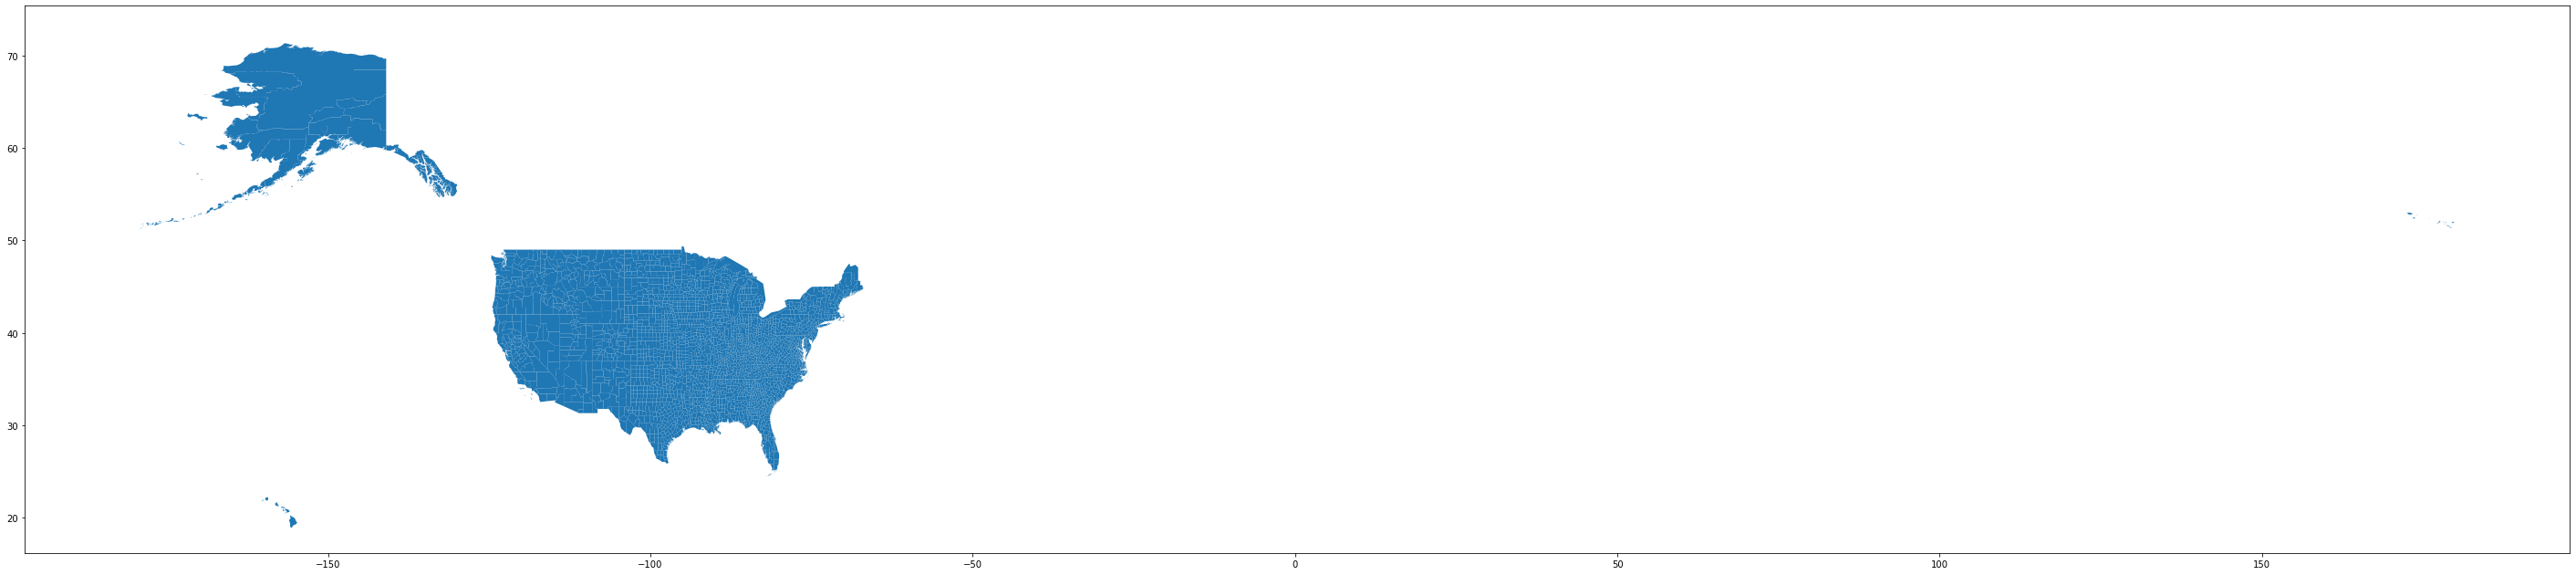

In [3]:
counties.plot(figsize=(50, 50))

In [4]:
counties.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
0,244,USA,United States,1,Alabama,1,Autauga,US.AL.AU,0,None,County,County,None,None,"POLYGON ((-86.91668 32.66431, -86.82678 32.660..."
1,244,USA,United States,1,Alabama,2,Baldwin,US.AL.BD,0,None,County,County,None,None,"MULTIPOLYGON (((-87.51056 30.33972, -87.51083 ..."
2,244,USA,United States,1,Alabama,3,Barbour,US.AL.BR,0,None,County,County,None,None,"POLYGON ((-85.13026 31.76386, -85.13504 31.768..."
3,244,USA,United States,1,Alabama,4,Bibb,US.AL.BI,0,None,County,County,None,None,"POLYGON ((-87.42078 32.87446, -87.42028 32.971..."
4,244,USA,United States,1,Alabama,5,Blount,US.AL.BU,0,None,County,County,None,None,"POLYGON ((-86.95322 33.81542, -86.95449 33.845..."


getting rid of Alaska and Hawaii for this example

In [5]:
counties = (counties[(counties.NAME_1 != 'Alaska') & 
                     (counties.NAME_1 != 'Hawaii')][
            ['NAME_1', 'NAME_2', 'geometry']].reset_index(drop=True))

<AxesSubplot:>

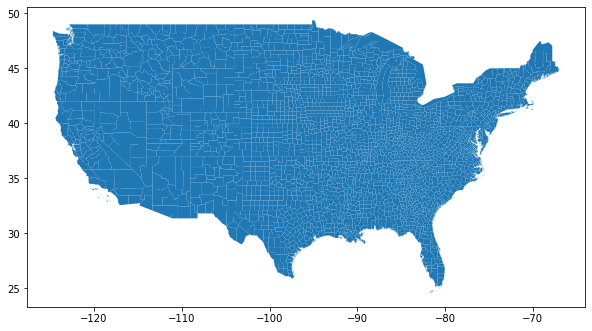

In [6]:
counties.plot(figsize=(10, 6))

In [7]:
suit = rasterio.open('data/suit/suit/hadr.adf')

<AxesSubplot:>

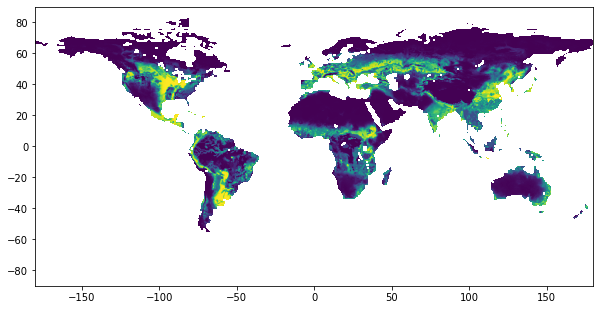

In [8]:
f, ax = plt.subplots(figsize=(10, 6))
show(suit, ax=ax)

In [9]:
suit.crs

this dataset doesnt have a projection. Let's fix that

In [10]:
infile = './data/suit/suit/hadr.adf'
input_raster = gdal.Open(infile)
output_raster = './data/agrisuit.tif'
warp = gdal.Warp(output_raster,input_raster,dstSRS='EPSG:4326')
warp = None # Closes the files

In [11]:
suit = rasterio.open('data/agrisuit.tif')

<AxesSubplot:>

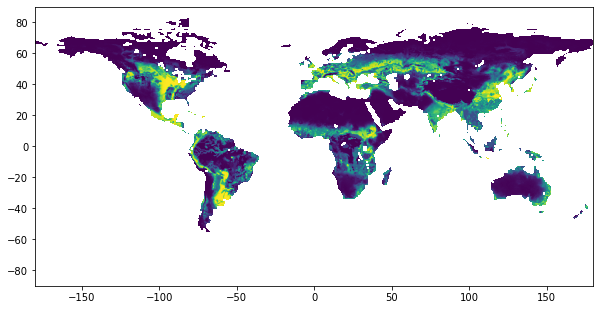

In [12]:
f, ax = plt.subplots(figsize=(10, 6))
show(suit, ax=ax)

In [13]:
suit.crs

CRS.from_epsg(4326)

getting the array and the transform

In [14]:
array = suit.read(1)
affine = suit.transform

Missing values are very large and negative for this raster -> need to fix

In [15]:
array[array < 0] = np.nan

In [16]:
zs1 = zonal_stats(counties, array, affine=affine, stats=['mean'], nodata=np.nan)    
zs2 = zonal_stats(counties, array, affine=affine, stats=['mean'], nodata=np.nan, all_touched=True)    
counties['mean_suit1'] = [x['mean'] for x in zs1]
counties['mean_suit2'] = [x['mean'] for x in zs2]

In [17]:
counties

,NAME_1,NAME_2,geometry,mean_suit1,mean_suit2
0,Alabama,Autauga,"POLYGON ((-86.91668 32.66431, -86.82678 32.660...",NaN,0.270750
1,Alabama,Baldwin,"MULTIPOLYGON (((-87.51056 30.33972, -87.51083 ...",0.043000,0.093000
2,Alabama,Barbour,"POLYGON ((-85.13026 31.76386, -85.13504 31.768...",0.178000,0.260750
3,Alabama,Bibb,"POLYGON ((-87.42078 32.87446, -87.42028 32.971...",NaN,0.240750
4,Alabama,Blount,"POLYGON ((-86.95322 33.81542, -86.95449 33.845...",NaN,0.140250
...,...,...,...,...,...
3112,Wyoming,Sweetwater,"POLYGON ((-109.04901 41.00003, -109.08112 41.0...",0.169071,0.162250
3113,Wyoming,Teton,"POLYGON ((-111.04362 43.31358, -111.04391 43.4...",0.007200,0.063167
3114,Wyoming,Uinta,"POLYGON ((-110.04850 40.99883, -110.05729 40.9...",0.162500,0.181222
3115,Wyoming,Washakie,"POLYGON ((-107.10772 43.49963, -107.14559 43.4...",0.327500,0.312222


<AxesSubplot:>

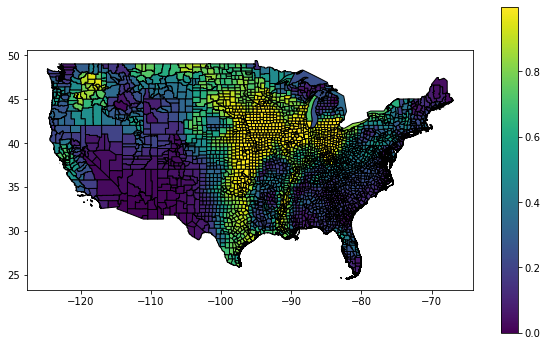

In [18]:
counties.plot(column='mean_suit2', cmap='viridis', edgecolor='k', legend=True, figsize=(10, 6))